# U.S. Income Growth

The goal of this notebook is to demonstrate which counties/states have had the most income growth over the last 15 years -- We are also interested in whether this income growth is correlated with the growth of particular industries in those geographical areas.

In [94]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as r
import statsmodels.formula.api as sm

from pandas_datareader import DataReader

%matplotlib inline

## The Data

We will be using the Bureau of Economic Analysis (BEA) data.

**Note**: To follow along, you will need to register for your own API key at https://apps.bea.gov/API/signup/index.cfm.

The BEA includes data on ...

In [3]:
base_url = "https://apps.bea.gov/api/data"

In [4]:
# Insert your API key here
api_key = "1917F45C-CA3C-4490-9410-3EAC28D64A06"

First, let's determine what datasets are available

The data will come in a JSON format -- This is effectively a group of nested dictionaries.

In [40]:
json.loads(
    r.get(base_url, params={"UserID": api_key, "method": "GETDATASETLIST"}).text
)["BEAAPI"]["Results"]["Dataset"]


[{'DatasetName': 'RegionalData',
  'DatasetDescription': 'The RegionalData dataset is obsolete. Please use the Regional dataset. See API documentation at apps.bea.gov/developers'},
 {'DatasetName': 'NIPA', 'DatasetDescription': 'Standard NIPA tables'},
 {'DatasetName': 'NIUnderlyingDetail',
  'DatasetDescription': 'Standard NI underlying detail tables'},
 {'DatasetName': 'MNE', 'DatasetDescription': 'Multinational Enterprises'},
 {'DatasetName': 'FixedAssets',
  'DatasetDescription': 'Standard Fixed Assets tables'},
 {'DatasetName': 'ITA',
  'DatasetDescription': 'International Transactions Accounts'},
 {'DatasetName': 'IIP',
  'DatasetDescription': 'International Investment Position'},
 {'DatasetName': 'GDPbyIndustry', 'DatasetDescription': 'GDP by Industry'},
 {'DatasetName': 'RegionalIncome',
  'DatasetDescription': 'Regional Income data sets'},
 {'DatasetName': 'RegionalProduct',
  'DatasetDescription': 'Regional Product data sets'},
 {'DatasetName': 'InputOutput', 'DatasetDescript

In [65]:
json.loads(r.get(base_url, params={
    "UserID": api_key,
    "method": "GetParameterValues",
    "DataSetName": "Regional",
    "ParameterName": "TableName",
    "ResultFormat": "json"
}).text)["BEAAPI"]["Results"]

{'ParamValue': [{'Key': 'ACArtsComp', 'Desc': 'ACPSA Compensation (NAICS)'},
  {'Key': 'ACArtsEmp', 'Desc': 'ACPSA Employment (NAICS)'},
  {'Key': 'ACArtsVA', 'Desc': 'ACPSA Value Added (NAICS)'},
  {'Key': 'ACComp', 'Desc': 'Total Compensation (NAICS)'},
  {'Key': 'ACCompLQ', 'Desc': 'Arts Compensation Location Quotient (NAICS)'},
  {'Key': 'ACCompRatio', 'Desc': 'Arts Compensation Ratio (NAICS)'},
  {'Key': 'ACEmp', 'Desc': 'Total Employment (NAICS)'},
  {'Key': 'ACEmpLQ', 'Desc': 'Arts Employment Location Quotient (NAICS)'},
  {'Key': 'ACEmpRatio', 'Desc': 'Arts Employment Ratio (NAICS)'},
  {'Key': 'ACVA', 'Desc': 'Total Value Added (NAICS)'},
  {'Key': 'ACVALQ', 'Desc': 'Arts Value Added Location Quotient (NAICS)'},
  {'Key': 'ACVARatio', 'Desc': 'Arts Value Added Ratio (NAICS)'},
  {'Key': 'CAEMP25N',
   'Desc': 'Total Full-Time and Part-Time Employment by NAICS Industry (NAICS)'},
  {'Key': 'CAEMP25S',
   'Desc': 'Total Full-Time and Part-Time Employment by SIC Industry (SIC)'},

In [53]:
json.loads(r.get(base_url, params={
    "UserID": api_key,
    "method": "GetParameterValuesFiltered",
    "DataSetName": "Regional",
    "TableName": "CAINC4",
    "TargetParameter": "LineCode",
    "ResultFormat": "json"
}).text)["BEAAPI"]["Results"]

{'ParamValue': [{'Key': '10', 'Desc': '[CAINC4] Personal income'},
  {'Key': '11', 'Desc': '[CAINC4] Nonfarm personal income'},
  {'Key': '12', 'Desc': '[CAINC4] Farm income'},
  {'Key': '20', 'Desc': '[CAINC4] Population'},
  {'Key': '30', 'Desc': '[CAINC4] Per capita personal income'},
  {'Key': '35', 'Desc': '[CAINC4] Earnings by place of work'},
  {'Key': '36',
   'Desc': '[CAINC4] Contributions for government social insurance'},
  {'Key': '37',
   'Desc': '[CAINC4] Employee and self-employed contributions for government social insurance'},
  {'Key': '38',
   'Desc': '[CAINC4] Employer contributions for government social insurance'},
  {'Key': '42', 'Desc': '[CAINC4] Adjustment for residence'},
  {'Key': '45', 'Desc': '[CAINC4] Net earnings by place of residence'},
  {'Key': '46', 'Desc': '[CAINC4] Dividends, interest, and rent'},
  {'Key': '47', 'Desc': '[CAINC4] Personal current transfer receipts'},
  {'Key': '50', 'Desc': '[CAINC4] Wages and salaries'},
  {'Key': '60', 'Desc': '

In [54]:
regional_income = json.loads(
    r.get(base_url, params={
        "UserID": api_key,
        "method": "GetData",
        "datasetname": "Regional",
        "Year": "2002,2017",
        "TableName": "SAINC4",
        "LineCode": "30",
        "GeoFips": "COUNTY",
        "ResultFormat": "json"
    }).text
)


Get CPI data from FRED to make sure we can convert from 2002 to 2017 dollars

In [73]:
cpi = (
    DataReader("CPIAUCSL", "fred", start=2000, end=2018)
    .resample("A")
    .mean()
)

In [88]:
convert_2002_to_2017 = (
    cpi.loc["2017", "CPIAUCSL"].values / cpi.loc["2002", "CPIAUCSL"].values
)[0]

In [89]:
convert_2002_to_2017

1.3628660118606373

Let's separate out the geographical codes so that we can reference them back and forth later

In [55]:
geofips = pd.DataFrame(regional_income["BEAAPI"]["Results"]["Data"]).loc[:, ["GeoFips", "GeoName"]]

fip_2_name = geofips.set_index("GeoFips").to_dict()["GeoName"]
name_2_fip = geofips.set_index("GeoName").to_dict()["GeoFips"]

In [56]:
fip_2_name["00000"]

'United States'

In [57]:
name_2_fip["United States"]

'00000'

Now, we make the income data into a usable data structure

In [58]:
df_income = pd.DataFrame(regional_income["BEAAPI"]["Results"]["Data"])
df_income = (
    df_income.drop(["CL_UNIT", "Code", "NoteRef", "UNIT_MULT", "GeoName"], axis=1)
             .rename(columns={"TimePeriod": "Year", "DataValue": "Income"})
             .query("GeoFips < '57000'")
             .assign(
                 Income=lambda x: pd.to_numeric(x["Income"].str.replace(",", ""), errors="coerce"),
                 FipsType=lambda x: x["GeoFips"].map(
                     lambda y: "Country" if y == "00000" else "State" if int(y) % 1000 == 0 else "County"
                 ),
             )
             .set_index(["Year", "GeoFips"])
)

In [90]:
df_income.head()

,,Income,FipsType
Year,GeoFips,,
2002,00000,31832,Country
2017,00000,51731,Country
2002,01000,25706,State
2017,01000,40802,State
2002,02000,34564,State


Now let's ask some basic questions of our data:

Which state has the highest per capita income in 2002? In 2017?

In [60]:
state_max = df_income.loc["2002", :].query("FipsType == 'State'")["Income"].idxmax()

fip_2_name[state_max]

'District of Columbia'

In [61]:
state_max = df_income.loc["2017", :].query("FipsType == 'State'")["Income"].idxmax()

fip_2_name[state_max]

'District of Columbia'

Which state has the lowest per capita income in 2002? In 2017?

In [62]:
state_max = df_income.loc["2002", :].query("FipsType == 'State'")["Income"].idxmin()

fip_2_name[state_max]

'Mississippi'

In [63]:
state_max = df_income.loc["2017", :].query("FipsType == 'State'")["Income"].idxmin()

fip_2_name[state_max]

'Mississippi'

Let's make a figure of where each state's per capital income was in 2002 vs 2017

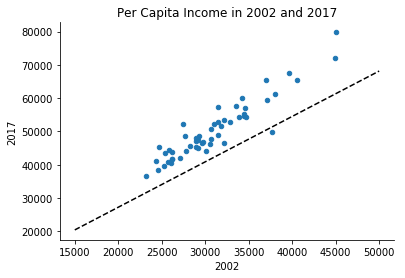

In [99]:
fig, ax = plt.subplots()

df_income["Income"].unstack(level="Year").plot(kind="scatter", x="2002", y="2017", ax=ax)

x = np.linspace(15000, 50000, 1000)
y = convert_2002_to_2017*x
ax.plot(x, y, "k--", linewidth=1.5)

ax.set_title("Per Capita Income in 2002 and 2017")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

Now let's load up our employment data

In [100]:
json.loads(r.get(base_url, params={
    "UserID": api_key,
    "method": "GetParameterValuesFiltered",
    "DataSetName": "Regional",
    "TableName": "SAEMP25N",
    "TargetParameter": "LineCode",
    "ResultFormat": "json"
}).text)["BEAAPI"]["Results"]

{'ParamValue': [{'Key': '10', 'Desc': '[SAEMP25N] Total employment'},
  {'Key': '100',
   'Desc': '[SAEMP25N] Private nonfarm employment: Forestry, fishing, and related activities (NAICS:113-115)'},
  {'Key': '1000',
   'Desc': '[SAEMP25N] Private nonfarm employment: Finance and insurance (NAICS:52)'},
  {'Key': '1001',
   'Desc': '[SAEMP25N] Private nonfarm employment: Monetary Authorities-central bank (NAICS:521)'},
  {'Key': '1002',
   'Desc': '[SAEMP25N] Private nonfarm employment: Credit intermediation and related activities (NAICS:522)'},
  {'Key': '1003',
   'Desc': '[SAEMP25N] Private nonfarm employment: Securities, commodity contracts, and other financial investments and related activities (NAICS:523)'},
  {'Key': '1004',
   'Desc': '[SAEMP25N] Private nonfarm employment: Insurance carriers and related activities (NAICS:524)'},
  {'Key': '1005',
   'Desc': '[SAEMP25N] Private nonfarm employment: Funds, trusts, and other financial vehicles (NAICS:525)'},
  {'Key': '101',
   'De

In [101]:
industry_employment = json.loads(
    r.get(base_url, params={
        "UserID": api_key,
        "method": "GetData",
        "datasetname": "Regional",
        "Year": "2002,2017",
        "TableName": "SAEMP25N",
        "LineCode": "906",
        "GeoFips": "COUNTY",
        "ResultFormat": "json"
    }).text
)


In [112]:
df_employment = pd.DataFrame(industry_employment["BEAAPI"]["Results"]["Data"])
df_employment = (
    df_employment.drop(["CL_UNIT", "Code", "UNIT_MULT"], axis=1)
                 .rename(columns={"TimePeriod": "Year", "DataValue": "Employment"})
                 .query("GeoFips < '57000'")
                 .assign(
                     Employment=lambda x: pd.to_numeric(x["Employment"].str.replace(",", ""), errors="coerce"),
                 )
                 .set_index(["Year", "GeoFips"])
)

In [116]:
df = df_income.merge(df_employment, left_index=True, right_index=True)

In [127]:
df.head()

,,Income,FipsType,Employment,GeoName
Year,GeoFips,,,,
2002,00000,31832,Country,481600,United States
2017,00000,51731,Country,396100,United States
2002,01000,25706,State,3412,Alabama
2017,01000,40802,State,2531,Alabama
2002,02000,34564,State,345,Alaska


In [178]:
def compute_change(df):
    geofip = df.index.get_level_values("GeoFips").unique()[0]

    _x = df.loc[("2002", geofip)]
    _y = df.loc[("2017", geofip)]

    return (_y - _x) / _x

In [189]:
df = df.groupby(level="GeoFips").agg({
    "Employment": lambda x: compute_change(x),
    "Income": lambda x: compute_change(x),
    "GeoName": lambda x: x.iloc[0],
    "FipsType": lambda x: x.iloc[0]
})

,Employment,Income,GeoName,FipsType
GeoFips,,,,
00000,-0.177533,0.625126,United States,Country
01000,-0.258206,0.587256,Alabama,State
02000,-0.400000,0.654322,Alaska,State
04000,0.063229,0.556225,Arizona,State
05000,0.146312,0.686643,Arkansas,State
06000,-0.113347,0.752812,California,State
08000,0.242501,0.583038,Colorado,State
09000,-0.510243,0.606586,Connecticut,State
10000,-0.536384,0.327051,Delaware,State


In [158]:
inc_per_change = df.groupby(level="GeoFips")[["Income"]].agg(lambda x: compute_change(x, "Income"))
emp_per_change = df.groupby(level="GeoFips")[["Employment"]].agg(lambda x: compute_change(x, "Employment"))

In [167]:
df.groupby("GeoFips").agg({"Income": "mean", "Employment": "mean"})

,Income,Employment
GeoFips,,
00000,41781.5,438850.0
01000,33254.0,2971.5
02000,45872.0,276.0
04000,34564.0,10882.5
05000,32704.5,1775.0
06000,47118.5,58590.0
08000,44513.5,11476.0
09000,58497.0,3890.5
10000,43773.0,1599.0
